In [32]:
import pytesseract
import matplotlib.pyplot as plt
import platform
if platform.system() == "Windows":
    pytesseract.pytesseract.tesseract_cmd = r'C:\Users\B92383\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
custom_config = r'--oem 2 --psm 12 -l fra+eng'

In [33]:
import cv2
import numpy as np

In [34]:
from PIL import Image


image_source = cv2.imread('carte-grise-specimen_a4.jpg', cv2.IMREAD_GRAYSCALE)
image_source = np.array(Image.fromarray(image_source.copy()).rotate(76,resample=Image.BICUBIC, expand=True))
modele = cv2.resize((cv2.imread('template-carte_grise.jpg', cv2.IMREAD_GRAYSCALE)),(460,800))

# Initialiser l'extracteur de points d'intérêt SIFT
sift = cv2.SIFT_create()

# Trouver les points d'intérêt et calculer les descripteurs pour l'image source et le modèle
keypoints_source, descriptors_source = sift.detectAndCompute(image_source, None)
keypoints_modele, descriptors_modele = sift.detectAndCompute(modele, None)

# Utiliser FLANN pour trouver les correspondances entre les descripteurs des points d'intérêt
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(descriptors_source, descriptors_modele, k=2)

# Appliquer le ratio test pour filtrer les correspondances les plus robustes
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Obtenir les coordonnées des points correspondants
source_pts = np.float32([keypoints_source[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
modele_pts = np.float32([keypoints_modele[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Estimation de la matrice de transformation (rotation et translation) avec RANSAC
transformation_matrix, mask = cv2.estimateAffinePartial2D(source_pts, modele_pts, method=cv2.RANSAC)

# Obtenir l'angle de rotation à partir de la matrice de transformation
angle_of_rotation = np.degrees(np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0]))

# Appliquer la rotation à l'image source pour l'aligner avec le modèle
rotated_image = cv2.warpAffine(image_source, transformation_matrix, (image_source.shape[1], image_source.shape[0]))

# Dessiner les correspondances sur une nouvelle image
result_image = cv2.drawMatches(image_source, keypoints_source, rotated_image, keypoints_modele, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)



In [35]:
angle_of_rotation

74.85426204331426

In [36]:
def detect_angle_of_rotation(image_source):
    # Charger l'image source et le modèle
    
    modele = cv2.resize((cv2.imread('template-carte_grise.jpg', cv2.IMREAD_GRAYSCALE)),(460,800),interpolation=cv2.INTER_CUBIC)

    # Initialiser l'extracteur de points d'intérêt SIFT
    sift = cv2.SIFT_create()

    # Trouver les points d'intérêt et calculer les descripteurs pour l'image source et le modèle
    keypoints_source, descriptors_source = sift.detectAndCompute(image_source, None)
    keypoints_modele, descriptors_modele = sift.detectAndCompute(modele, None)

    # Utiliser FLANN pour trouver les correspondances entre les descripteurs des points d'intérêt
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors_source, descriptors_modele, k=2)

    # Appliquer le ratio test pour filtrer les correspondances les plus robustes
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Obtenir les coordonnées des points correspondants
    source_pts = np.float32([keypoints_source[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    modele_pts = np.float32([keypoints_modele[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimation de la matrice de transformation (rotation et translation) avec RANSAC
    transformation_matrix, mask = cv2.estimateAffinePartial2D(source_pts, modele_pts, method=cv2.RANSAC)

    # Obtenir l'angle de rotation à partir de la matrice de transformation
    angle_of_rotation = np.degrees(np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0]))

    rotated_image = cv2.warpAffine(image_source, transformation_matrix, (image_source.shape[1], image_source.shape[0]))

    # Dessiner les correspondances sur une nouvelle image
    result_image = cv2.drawMatches(image_source, keypoints_source, rotated_image, keypoints_modele, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(result_image)
    return angle_of_rotation

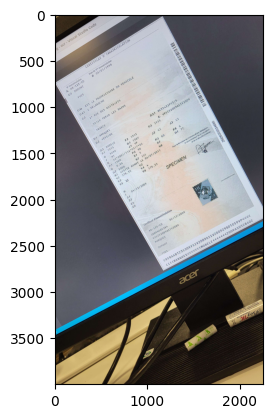

In [59]:
img_test = cv2.imread('testc_g.jpg',cv2.IMREAD_UNCHANGED)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_test)

180.0

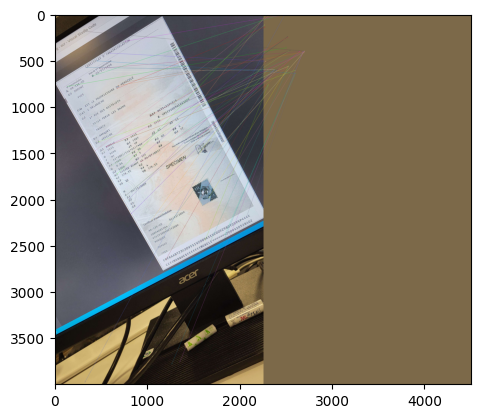

In [60]:
detect_angle_of_rotation(img_test)

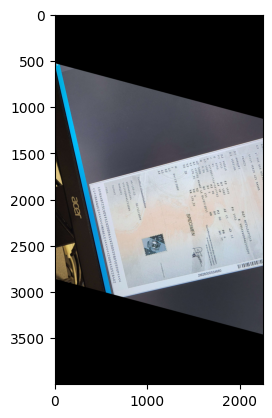

In [61]:
plt.imshow(np.array(Image.fromarray(img_test.copy()).rotate(-1 * int(detect_angle_of_rotation(img_test)))))

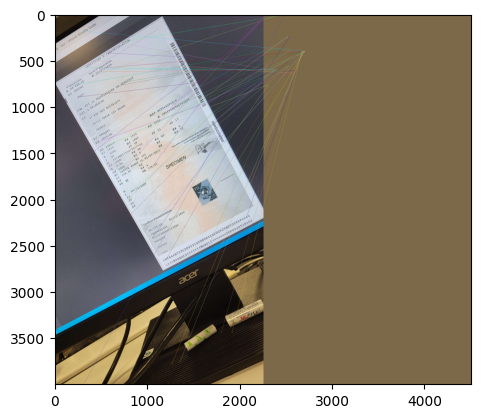

In [62]:
img_test__test = np.array(Image.fromarray(img_test.copy()).rotate(-1 * int(detect_angle_of_rotation(img_test)),resample=Image.BICUBIC, expand=True))

# Etape 1
### Standariser l'image

In [54]:
def resize_image(image):
    """
    Resize the input image to a fixed size of (1946, 1080).

    Parameters:
    - image: Input image (OpenCV format)

    Returns:
    - Resized image
    """
    # Resize the image to the fixed size
    resized_image = cv2.resize(image, (460, 800))

    return resized_image




def biggestRectangle(contours):
    max_area = 0
    indexReturn = -1
    for index in range(len(contours)):
        i = contours[index]
        area = cv2.contourArea(i)
        if area > 100:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.1 * peri, True)
            if area > max_area:
                max_area = area
                indexReturn = index
    return indexReturn


def image_brightness(img):
    """
    Process the input image by converting color space, applying gamma correction,
    and applying binary thresholding.

    Parameters:
    - img: Input image (OpenCV format)

    Returns:
    - Processed image
    """
    # Convert color space from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Apply gamma correction
    invGamma = 1.0 / 0.3
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gray = cv2.LUT(gray, table)

    # Apply binary thresholding
    _, thresh1 = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)

    return thresh1


def process_image(img):
    
    thresh1 = image_brightness(img)
    
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]

    indexReturn = biggestRectangle(contours)
    hull = cv2.convexHull(contours[indexReturn])

    mask = np.zeros_like(img)
    cv2.drawContours(mask, contours, indexReturn, 255, -1)
    out = np.zeros_like(img)
    out[mask == 255] = img[mask == 255]
    

    (y, x, _) = np.where(mask == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = img[topy:bottomy + 1, topx:bottomx + 1, :]
    out = resize_image(out)
    

    return out




# Define a function to trim and save an image
def trim_and_save(region_key, region_points, image):
    x, y, w, h = cv2.boundingRect(np.array(region_points))
    cropped_image = image[y:y+h, x:x+w]
    cv2.imwrite(f"./img/{region_key}_cropped.jpg", cropped_image)



def image2text(cropped_image_path):
    text = ''
    
    cropped_image = cv2.imread(cropped_image_path)

    text = pytesseract.image_to_string(cropped_image, config=custom_config)

    if len(text)!=0:
        return text
    else:
        print("no text detected")


        




In [39]:
# Load your image
image_path = "/home/apprenant/Bureau/ocr/carte-grise-specimen.jpg"
# image = Image.open(image)
frame = cv2.imread(image_path)
print(frame.shape)
# print(frame)
frame = process_image(frame)

print(frame.shape)

(2656, 1472, 3)
(800, 460, 3)


# Etape 2 :
### Trouver les points de chaque element dans la photo

In [40]:
import numpy as np
import cv2

def mouse_drawing(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print("Left click")
        circles.append((x, y))

circles = []

# Load your image
# image_path = "img\carte-grise-specimen.jpg"
# frame = cv2.imread(image_path)

cv2.namedWindow("Frame")
if len(circles) < 4:
    cv2.setMouseCallback("Frame", mouse_drawing)

while True:
    for center_position in circles:
        cv2.circle(frame, center_position, 2, (0, 0, 255), -1)
    
    points = np.array(circles)
    if len(circles) >= 4:
        cv2.polylines(frame, np.int32([points]), 1, (255, 255, 255))

    cv2.imshow("Frame", frame)
    

    key = cv2.waitKey(1)
    if key == 27:
        break
    elif key == ord("d"):
        circles = []

cv2.destroyAllWindows()
print(circles)


[]


In [41]:
regions_dict = {
    'points_N_immatriculation':[(31, 35), (31, 46), (100, 49), (101, 35)],
    'points_titre_document': [(113, 0), (114, 15), (339, 15), (336, 0)],
    'points_d_2': [(38, 242), (38, 262), (359, 262), (359, 242)],
    'points_E': [(288, 276), (289, 293), (412, 295), (412, 275)],
    'points_Date_de_1er_immarticulation': [(145, 37), (146, 50), (228, 51), (226, 36)]
}

# Accessing values for a specific key
print(regions_dict['points_titre_document'][0])

(113, 0)


# Etape 3
### couper les elements et les save 

In [42]:
import cv2

# Iterate through regions and trim/save images
for region_key, region_points in regions_dict.items():
    trim_and_save(region_key, region_points, frame)

# Etape 4
### Passer le PCR pour chaque image

In [43]:
while True:
    for region_key, value in regions_dict.items():
        cv2.rectangle(frame, value[0], value[2], (0,0,255),2,2)
         # Load the saved cropped image
        cropped_image_path = f"{region_key}_cropped.jpg"
        # cropped_image = cv2.imread(cropped_image_path)
        word_found = image2text(cropped_image_path)
        # print(f"{region_key} : {word_found}")
        cv2.putText(frame, str(word_found), value[0],1,1,(0,0,255),1)

    
 
    cv2.imshow("Frame", frame)

    key = cv2.waitKey(1)
    if key == 27:
        break
  
cv2.destroyAllWindows()

In [44]:
liste_var = {}
for region_key, value in regions_dict.items():
        cv2.rectangle(frame, value[0], value[2], (0,0,255),2,2)
         # Load the saved cropped image
        cropped_image_path = f"./img/{region_key}_cropped.jpg"
        # cropped_image = cv2.imread(cropped_image_path)
        word_found = image2text(cropped_image_path)
        liste_var[region_key]=word_found.strip()

In [45]:
liste_var

{'points_N_immatriculation': 'AB-123-CD',
 'points_titre_document': "CERTIFICAT D'IMNATAICULATION",
 'points_d_2': 'VERSION',
 'points_E': 'WFSIV2009ASIV2009',
 'points_Date_de_1er_immarticulation': '05/01/1996'}

In [72]:
from PyPDF2 import PdfWriter, PdfReader
from io import BytesIO
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

buffer = BytesIO()

# create a new PDF with Reportlab
p = canvas.Canvas(buffer, pagesize=A4)
dict_pos = {
    'points_N_immatriculation':[50, 705],
    'points_d_2': [50, 630],
    'points_E': [50, 610],
    'points_Date_de_1er_immarticulation': [445, 705]
}
for region_key in dict_pos.keys():
    if "Date" not in region_key:
        p.drawString(*dict_pos[region_key], liste_var[region_key],charSpace=2)
    else:
        p.drawString(*dict_pos[region_key], liste_var[region_key].replace("/",""),charSpace=8.5)
p.showPage()
p.save()

#move to the beginning of the StringIO buffer
buffer.seek(0)
newPdf = PdfReader(buffer)

# #######DEBUG NEW PDF created#############
# pdf1 = buffer.getvalue()
# open('pdf1.pdf', 'wb').write(pdf1)
#########################################
# read your existing PDF
existingPdf = PdfReader(open('cerfa_13750-07.pdf', 'rb'))
output = PdfWriter()
# add the "watermark" (which is the new pdf) on the existing page
page = existingPdf.pages[0]
page.merge_page(newPdf.pages[0])
output.add_page(page)
# finally, write "output" to a real file
outputStream = open('output.pdf', 'wb')
output.write(outputStream)
outputStream.close()